<a href="https://colab.research.google.com/github/Pavle-Ilic/MNIST-Using-K-means/blob/master/TaxiDeepQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev

In [18]:

from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [4]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# **HyperParameters**

In [5]:
num_iters = 20000
initial_collect_steps = 100
collect_steps_per_iter = 1
replay_buffer_max_length = 100000

batch_size = 64
learning_rate = 1e-3
log_interval = 200

num_eval_epis = 10
eval_interval = 1000

# **Environment**

In [6]:
env = suite_gym.load('CartPole-v0')


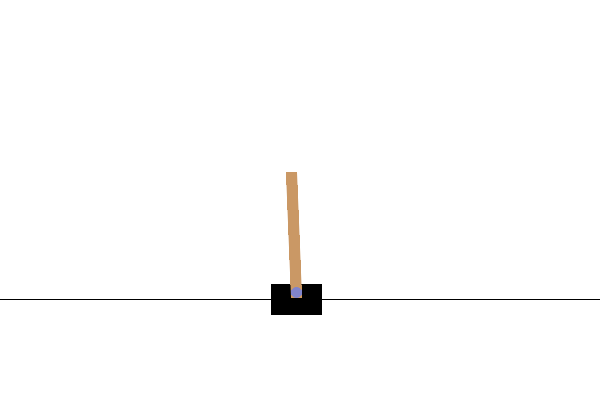

In [7]:
env.reset()
PIL.Image.fromarray(env.render())

In [8]:
print(f'Observation space: \n{env.time_step_spec().observation}')

Observation space: 
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [9]:
print(f'Reward Spec: \n{env.time_step_spec().reward}')

Reward Spec: 
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [10]:
print(f'Action Spec: \n{env.action_spec()}')

Action Spec: 
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [11]:
time_step = env.reset()
print(f'Time step: \n{time_step}')

Time step: 
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.03284045, -0.02997734,  0.0335369 , -0.04899519], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})


In [12]:
action = np.array(1, dtype = np.int32)
print(action)


1


In [13]:
next_time_step = env.step(action)
print(f'Next time step: \n {next_time_step}')

Next time step: 
 TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.03343999,  0.16464807,  0.032557  , -0.33091116], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


In [14]:
train_py_env = suite_gym.load('CartPole-v0')
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_py_env = suite_gym.load('CartPole-v0')
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [15]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units, 
      activation = tf.keras.activations.relu,
      kernel_initializer= tf.keras.initializers.VarianceScaling(
          scale = 2.0, mode = 'fan_in', distribution = 'truncated_normal'))
  
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation = None,
    kernel_initializer = tf.keras.initializers.RandomUniform(
        minval = -0.03, maxval = 0.03),
        bias_initializer = tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DdqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network = q_net,
    optimizer = optimizer,
    td_errors_loss_fn = common.element_wise_squared_loss,
    train_step_counter = train_step_counter
)

agent.initialize()

# **Policies**

In [19]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [32]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [33]:
example_enviorment = tf_py_environment.TFPyEnvironment(suite_gym.load('CartPole-v0'))

In [34]:
time_sep = example_enviorment.reset()

In [ ]:
#random_policy.action(time_step)

# **Metrics and Evaluation**

In [39]:
def compute_avg_return(environment, policy, num_episodes = 10):
  total_return = 0.0
  for _ in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [58]:
compute_avg_return(eval_env, random_policy, num_eval_epis)

1.1

# **Replay Buffer**

In [62]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name = table_name,
    sequence_length = 2,
    local_server = reverb_server
)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length = 2
)



In [63]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [64]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

# **Data Collection**

In [65]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
        random_policy, use_tf_function = True),
        [rb_observer],
        max_steps = initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([ 0.044379  ,  0.04840463, -0.05236531, -0.12428109], dtype=float32),
  'reward': array(1., dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [66]:
iter(replay_buffer.as_dataset()).next()

(Trajectory(
 {'action': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>,
  'discount': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>,
  'next_step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>,
  'observation': <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[ 0.03009618, -0.02709766, -0.08117093, -0.11284393],
        [ 0.02955422, -0.22096835, -0.08342781,  0.15316656]],
       dtype=float32)>,
  'policy_info': (),
  'reward': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>}),
 SampleInfo(key=<tf.Tensor: shape=(2,), dtype=uint64, numpy=array([2867768061958201869, 2867768061958201869], dtype=uint64)>, probability=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.01010101, 0.01010101])>, table_size=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([99, 99])>, priority=<tf.Tensor: shape=(2

In [67]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size = batch_size,
    num_steps = 2
).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [69]:
iterator = iter(dataset)
print(iterator)

In [ ]:
iterator.next()

# **Training the agent**

In [ ]:
try:
  %%time
except:
  pass

#Optional Optimization by wrapping some of the code in a graph using TF function
agent.train = common.function(agent.train)

#reset the train step
agent.train_step_counter.assign(0)

#Evaluate the agent's policy once before training
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_epis)
returns = [avg_return]

#reste the env
time_step = train_py_env.reset()

#create a driver to eollect experience
collect_driver = py_driver.PyDriver(
    env, py_tf_eager_policy.PyTFEagerPolicy(
        agent.collect_policy, use_tf_function = True
    ),
    [rb_observer],
    max_steps = collect_steps_per_iter
)

for _ in range(num_iters):

  #collect a few steps and save to the replay buffer
  time_step, _ = collect_driver.run(time_step)

  #Sample a batch of data from the buffer and update the agent's network
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_epis)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)
    

# **Visualization**

(2.3600000500679017, 25.0)

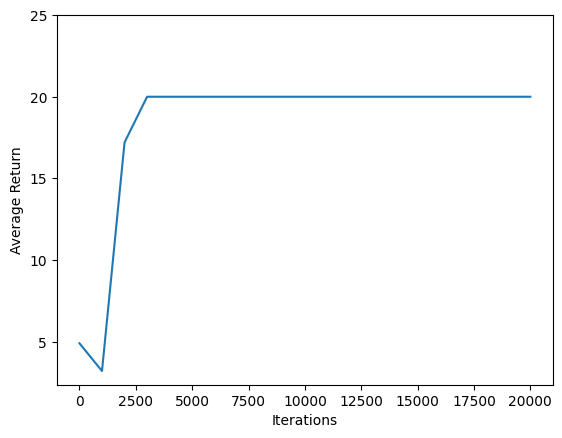

In [81]:
iterations = range(0, num_iters + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top = 25)



In [78]:
def embed_mp4(filename):
  video = open(filename, 'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [82]:
def create_policy_eval_video(policy, filename, num_episodes = 5, fps = 30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps = fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

In [80]:
create_policy_eval_video(random_policy, "random-agent")